In [1]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from scipy.interpolate import UnivariateSpline # curva sigmoide suavizada
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # procedimento Stepwise
from scipy import stats # estatística chi2
import plotly.graph_objects as go # gráficos 3D
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statsmodels.discrete.discrete_model import MNLogit # estimação do modelo
                                                        #logístico multinomial
import warnings
warnings.filterwarnings('ignore')

In [5]:
df_challenger = pd.read_csv('../data/challenger.csv',delimiter=',')
df_challenger

,desgaste,temperatura,pressão,t
0,0,66,50,1
1,1,70,50,2
2,0,69,50,3
3,0,68,50,4
4,0,67,50,5
5,0,72,50,6
6,0,73,100,7
7,0,70,100,8
8,1,57,200,9
9,1,63,200,10


In [6]:
# Características das variáveis do dataset
df_challenger.info()

# Estatísticas univariadas
df_challenger.describe()

# desgaste: quantidade de vezes em que ocorreu stress térmico
# temperatura: temperatura de lançamento (graus ºF)
# pressão: pressão de verificação de vazamento (psi: libra-força por
    #polegada ao quadrado)
# t: teste para o lançamento (id)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   desgaste     23 non-null     int64
 1   temperatura  23 non-null     int64
 2   pressão      23 non-null     int64
 3   t            23 non-null     int64
dtypes: int64(4)
memory usage: 868.0 bytes


,desgaste,temperatura,pressão,t
count,23.000000,23.000000,23.000000,23.00000
mean,0.304348,69.565217,152.173913,12.00000
std,0.558796,7.057080,68.221332,6.78233
min,0.000000,53.000000,50.000000,1.00000
25%,0.000000,67.000000,75.000000,6.50000
50%,0.000000,70.000000,200.000000,12.00000
75%,0.500000,75.000000,200.000000,17.50000
max,2.000000,81.000000,200.000000,23.00000


In [7]:
# Criação da variável dependente binária 'falha'

# Não há uma variável binária para servir como uma variável dependente, certo?
# Então vamos criá-la, considerando a ocorrência de desgastes de peças como a
# ocorrência de um evento que chamaremos de 'falha':

df_challenger.loc[df_challenger['desgaste'] != 0 , 'falha'] = 1
df_challenger.loc[df_challenger['desgaste'] == 0, 'falha'] = 0

# Transformando a variável 'falha' para o tipo 'int' (poderia também deixar
# como 'float'), a fim de que seja possível estimar o modelo por meio da
# função 'sm.Logit.from_formula'

df_challenger.info()

df_challenger['falha'] = df_challenger['falha'].astype('int64')

df_challenger.info()

df_challenger

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   desgaste     23 non-null     int64  
 1   temperatura  23 non-null     int64  
 2   pressão      23 non-null     int64  
 3   t            23 non-null     int64  
 4   falha        23 non-null     float64
dtypes: float64(1), int64(4)
memory usage: 1.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   desgaste     23 non-null     int64
 1   temperatura  23 non-null     int64
 2   pressão      23 non-null     int64
 3   t            23 non-null     int64
 4   falha        23 non-null     int64
dtypes: int64(5)
memory usage: 1.0 KB


,desgaste,temperatura,pressão,t,falha
0,0,66,50,1,0
1,1,70,50,2,1
2,0,69,50,3,0
3,0,68,50,4,0
4,0,67,50,5,0
5,0,72,50,6,0
6,0,73,100,7,0
7,0,70,100,8,0
8,1,57,200,9,1
9,1,63,200,10,1


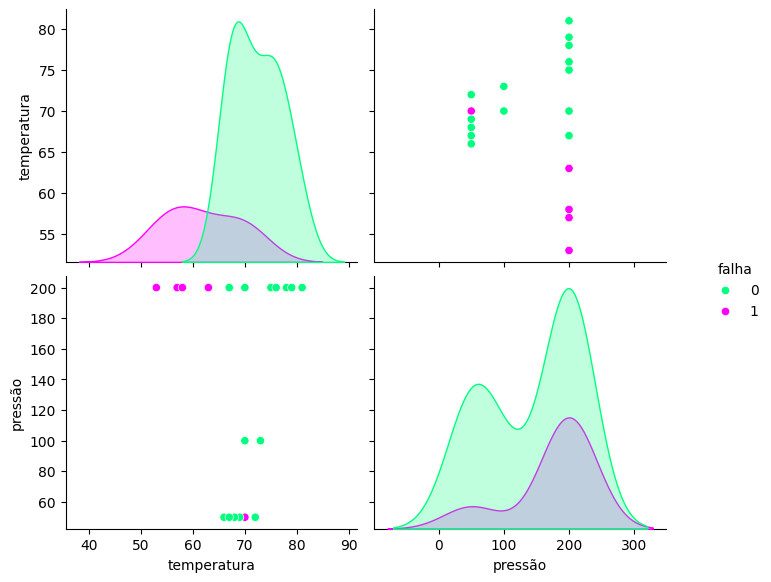

In [8]:
# Gráfico 'pairplot' com scatters e KDEs por 'falha'

cores_desejadas = {0: 'springgreen', 1: 'magenta'}

g = sns.pairplot(df_challenger[['falha','temperatura','pressão']], hue='falha',
                 palette=cores_desejadas)
g.fig.set_size_inches(8, 6)
plt.show()

In [9]:
# Estimação do modelo logístico binário pela função 'sm.Logit.from_formula'
# ('statsmodels.api')

# O modelo a seguir também pode ser estimado por meio da função 'smf.glm'
# ('statsmodels.formula.api')

modelo_challenger = sm.Logit.from_formula('falha ~ temperatura + pressão',
                                          df_challenger).fit()

# Parâmetros do 'modelo_challenger'
modelo_challenger.summary()

Optimization terminated successfully.
         Current function value: 0.305063
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  falha   No. Observations:                   23
Model:                          Logit   Df Residuals:                       20
Method:                           MLE   Df Model:                            2
Date:                Tue, 27 Aug 2024   Pseudo R-squ.:                  0.4685
Time:                        19:13:58   Log-Likelihood:                -7.0164
converged:                       True   LL-Null:                       -13.201
Covariance Type:            nonrobust   LLR p-value:                  0.002061
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      21.8436     11.936      1.830      0.067      -1.551      45.239
temperatura    -0.3501      0.173     -2.024      0.043      -0.689      -0.011
pressão         0.0060      0.010      0.616      0.538      -0.013       0.025
===============================================================================
"""

In [10]:
# Procedimento Stepwise

# Carregamento da função 'stepwise' do pacote 'statstests.process'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

from statstests.process import stepwise

# Estimação do modelo por meio do procedimento Stepwise
step_challenger = stepwise(modelo_challenger, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 falha ~ Q('temperatura') + Q('pressão')
Optimization terminated successfully.
         Current function value: 0.305063
         Iterations 8

 Discarding atribute "Q('pressão')" with p-value equal to 0.5378022290437207 

Estimating model...: 
 falha ~ Q('temperatura')
Optimization terminated successfully.
         Current function value: 0.313604
         Iterations 8

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('pressão')", 'p-value': np.float64(0.5378022290437207)}

 Model after stepwise process...: 
 falha ~ Q('temperatura') 

                           Logit Regression Results                           
Dep. Variable:                  falha   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Tue, 27 Aug 20

In [11]:
# Fazendo predições para o modelo 'step_challenger'

# Exemplo 1: qual a probabilidade média de falha a 70ºF (~21.11ºC)?
step_challenger.predict(pd.DataFrame({'temperatura':[70]}))

# Exemplo 2: qual a probabilidade média de falha a 77ºF (25ºC)?
step_challenger.predict(pd.DataFrame({'temperatura':[77]}))

# Exemplo 3: qual a probabilidade média de falha a 34ºF (~1.11ºC)?
# Temperatura no momento do lançamento
step_challenger.predict(pd.DataFrame({'temperatura':[34]}))

0    0.999988
dtype: float64

In [12]:
# Atribuindo uma coluna no dataframe para os resultados

df_challenger['phat'] = step_challenger.predict()

df_challenger

,desgaste,temperatura,pressão,t,falha,phat
0,0,66,50,1,0,0.394770
1,1,70,50,2,1,0.130777
2,0,69,50,3,0,0.178373
3,0,68,50,4,0,0.238539
4,0,67,50,5,0,0.311309
5,0,72,50,6,0,0.067389
6,0,73,100,7,0,0.047688
7,0,70,100,8,0,0.130777
8,1,57,200,9,1,0.946496
9,1,63,200,10,1,0.662129


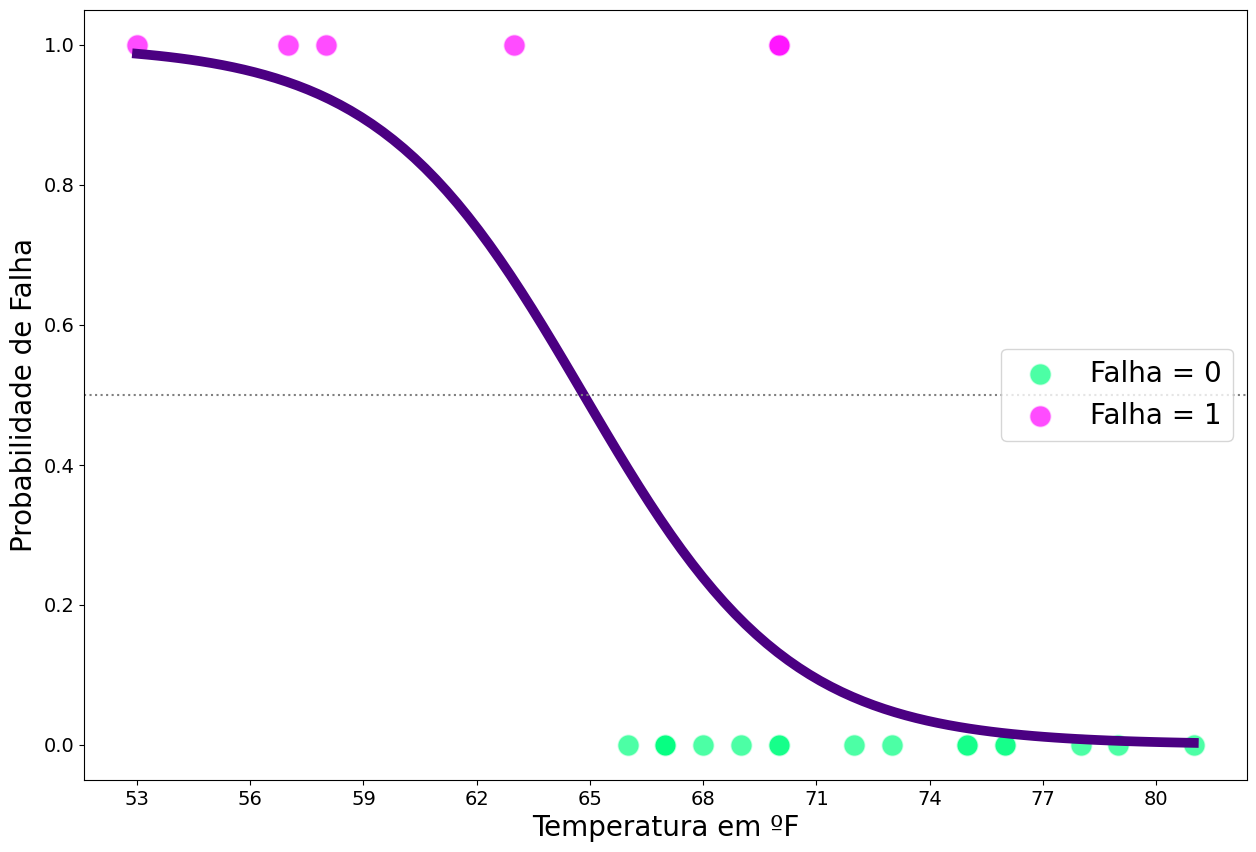

In [13]:
# Construção da sigmoide
# Probabilidade de evento em função da variável 'temperatura'    

plt.figure(figsize=(15,10))
sns.scatterplot(x=df_challenger['temperatura'][df_challenger['falha'] == 0],
                y=df_challenger['falha'][df_challenger['falha'] == 0],
                color='springgreen', alpha=0.7, s=250, label='Falha = 0')
sns.scatterplot(x=df_challenger['temperatura'][df_challenger['falha'] == 1],
                y=df_challenger['falha'][df_challenger['falha'] == 1],
                color='magenta', alpha=0.7, s=250, label='Falha = 1')
sns.regplot(x=df_challenger['temperatura'], y=df_challenger['falha'],
            logistic=True, ci=None, scatter=False,
            line_kws={'color': 'indigo', 'linewidth': 7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Temperatura em ºF', fontsize=20)
plt.ylabel('Probabilidade de Falha', fontsize=20)
plt.xticks(np.arange(df_challenger['temperatura'].min(),
                     df_challenger['temperatura'].max() + 0.01, 3),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(fontsize=20, loc='center right')
plt.show()

In [15]:
# Nossa homenagem aos astronautas

from PIL import Image
import requests
from io import BytesIO

url = "https://img.ibxk.com.br///2016/01/29/29182307148581.jpg?w=1200&h=675&mode=crop&scale=both"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.show()

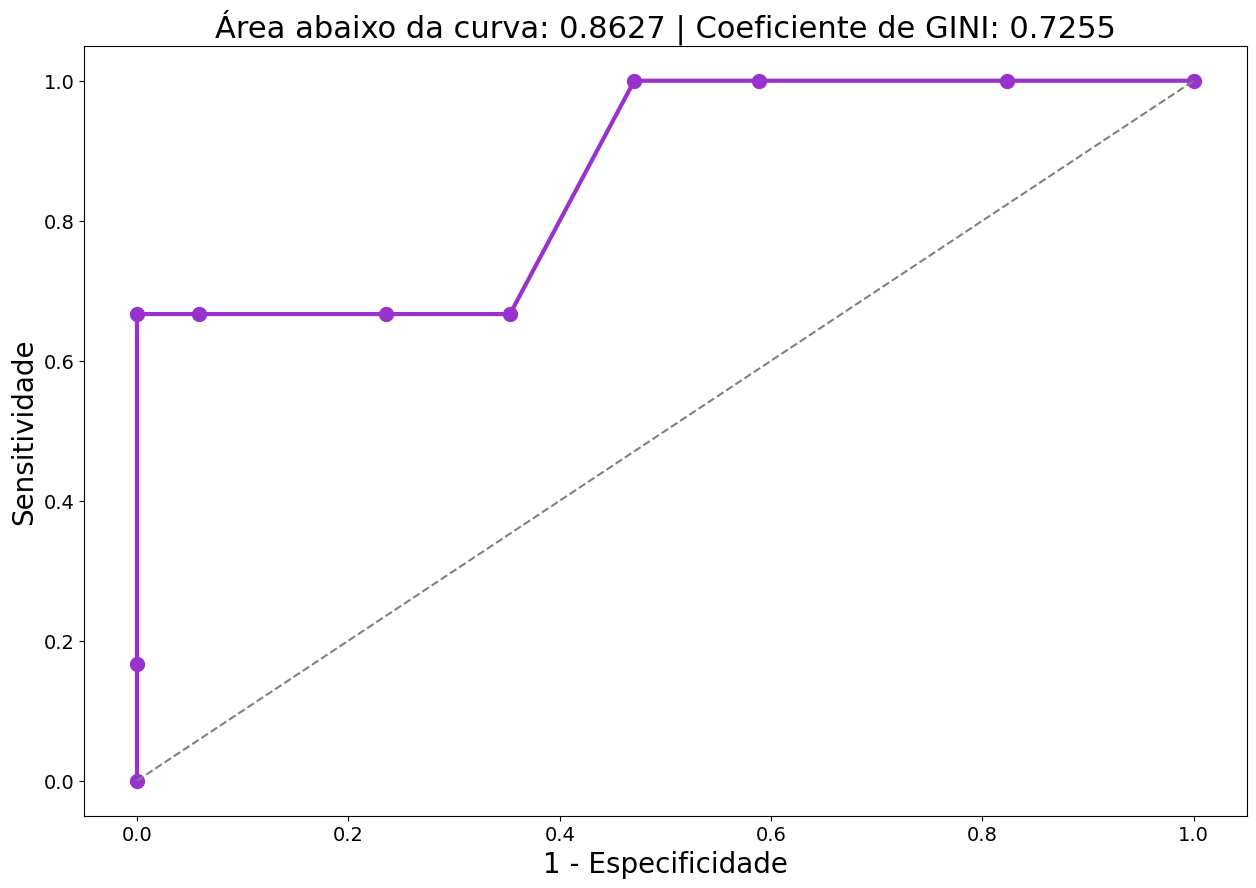

In [18]:
# Log-lik
step_challenger.llf

# Construção da curva ROC

from sklearn.metrics import roc_curve, auc

# Função 'roc_curve' do pacote 'metrics' do sklearn

fpr, tpr, thresholds =roc_curve(df_challenger['falha'], df_challenger['phat'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensitividade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()